In [1]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import cv2
import math
import seaborn as sns
import gc

print(os.listdir("../input"))

from scipy import signal
from scipy.io import wavfile
import matplotlib.pyplot as plt
import seaborn as sns
from keras import utils

%matplotlib inline

['train', 'sample_submission.csv']


Using TensorFlow backend.


## Data Processing

In [2]:
train_path = "../input/train/audio"
train = list(os.listdir(train_path))
specific_labels = ["yes","no","up","down","left","right","on","off","stop","go"]
background_labels = ["_background_noise_"]
unknown_labels = [i for i in train if i not in (specific_labels and background_labels)]

In [3]:
background = [f for f in os.listdir(os.path.join(train_path, '_background_noise_')) if f.endswith(".wav")]
background_noise = []

In [4]:
#https://www.kaggle.com/ollmer/labels-spectrograms-exploration
def spectrogram(file, label):
    eps=1e-10
    sample_rate, samples = wavfile.read(str(train_audio_path) + '/' + label + '/' + file)
    frequencies, times, spectrogram = signal.stft(samples, sample_rate, nperseg = sample_rate/50, noverlap = sample_rate/75)
    return np.log(np.abs(spectrogram).T+eps)

In [5]:
#https://www.kaggle.com/ollmer/labels-spectrograms-exploration
#According to Nyquist Sampling theorem the sampling frequency to produce 
#the exact original waveform should be double the original frequency of the signal.
#loading background in spectrograms
def load_background():
    eps=1e-10
    background_noise = []
    for wav in background :
        path = os.path.join(os.path.join(train_path,'_background_noise_'),wav)
        #print(path)
        sr, s = wavfile.read(path) #sample rate, sample
        nperseg = int(round(20 * sr / 1e3))
        noverlap = int(round(10 * sr / 1e3))
        frequencies, times, spectrogram = signal.spectrogram(s, fs=sr, window='hann', nperseg=nperseg, noverlap=noverlap, detrend=False)
        #print(np.shape(spectrogram))
        #print(frequencies.max())
        print(times.max())
        background_noise.append(np.log(np.abs(spectrogram).T+eps))

    #print(sr)
    return background_noise

background_feats = load_background()
np.shape(background_feats[1])

59.99
61.24


/opt/conda/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
/opt/conda/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


95.17
61.14
61.79
59.99


/opt/conda/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
/opt/conda/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


(6124, 161)

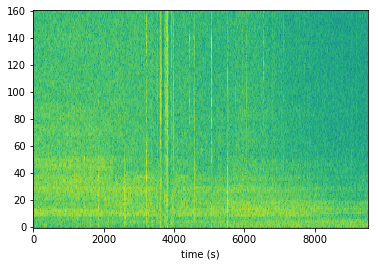

In [6]:
#generally,  We have 160 features for each frame
plt.xlabel("time (s)")
plt.imshow(background_feats[2].T, aspect='auto', origin='lower')

In [7]:
#to sample from random noises
#the input is the features and how many data points we would like to sample
#(99,161) is too much features - although that's the most common ratio we will be seeing in the other labels
def noise_sample(background_feats,sample_size,dim=(99,161)):
    file = np.random.randint(0,6) #selecting from 1 of the six background files
    #np.random.seed(42)
    new_bg_feats = []
    
    for i in range(sample_size):
        ind = np.random.randint(0,6)
        f = np.array(background_feats[ind])
        
        max_ = np.shape(background_feats[ind])[0] - 1
        start = np.random.randint(0,max_- dim[1])
        temp = f[start:start+dim[0],:]
        temp = cv2.resize(temp,dsize=None,fx=0.5,fy=0.5) #resize to 1/2 due to the fact that we run out of memory at (99,161)
        new_bg_feats.append(temp)
        #del temp
        #gc.collect()
        
    return new_bg_feats

background_feats = noise_sample(background_feats,40000)
np.shape(background_feats)

(40000, 50, 80)

In [8]:
#path generation helper function, input is a list of labels
def path_gen(lst,train_path):
    result_lst = []
    for label in lst:
        path = os.path.join(os.path.join(train_path,label))
        result_lst.append(path)
    return result_lst

path_gen(specific_labels,train_path)

['../input/train/audio/yes',
 '../input/train/audio/no',
 '../input/train/audio/up',
 '../input/train/audio/down',
 '../input/train/audio/left',
 '../input/train/audio/right',
 '../input/train/audio/on',
 '../input/train/audio/off',
 '../input/train/audio/stop',
 '../input/train/audio/go']

In [9]:
#Return both the features as well as the labels for the needed data with SPECIFIC labels.
def load_categ():
    #to load the specific labels
    global specific_labels
    path_lst = path_gen(specific_labels,train_path) #loading a path list
    label_lst = [] #to hold labels
    spec_features = []
    #print(path_lst)
    for i in range(len(path_lst)):
        temp = [files for files in os.listdir(path_lst[i]) if files.endswith(".wav")] 
        #print(temp)
        #print(label_lst)
        for wav in temp:
            path = os.path.join(path_lst[i],wav)
            #print(path)
            eps=1e-10
            sr, s = wavfile.read(path) #sample rate, sample
            nperseg = int(round(20 * sr / 1e3))
            noverlap = int(round(10 * sr / 1e3))
            frequencies, times, spectrogram = signal.spectrogram(s, fs=sr, window='hann', nperseg=nperseg, noverlap=noverlap, detrend=False)
            spec_features.append(np.log(np.abs(spectrogram).T+eps))
            label_lst.append(specific_labels[i])
            #print(np.shape(np.log(np.abs(spectrogram).T+eps)))
            #break
            
    return label_lst,spec_features

label_lst,spec_feats = load_categ()

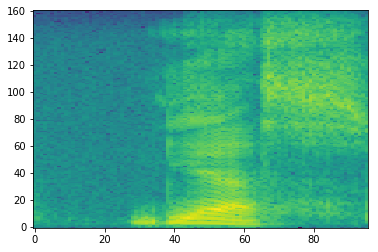

In [10]:
#example
plt.imshow(spec_feats[4].T, aspect='auto', origin='lower')

In [11]:
#return the features for UNKNOWN samples
def load_unknown():
    global unknown_labels
    #print(unknown_labels)
    path_lst = path_gen(unknown_labels,train_path) #loading a path list
    unknwn_features = []
    #print(path_lst)
    for i in range(len(path_lst)):
        #print(path_lst[i])
        temp = [files for files in os.listdir(path_lst[i]) if files.endswith(".wav")] 
        for wav in temp:
            path = os.path.join(path_lst[i],wav)         
            eps=1e-10
            sr, s = wavfile.read(path) #sample rate, sample
            nperseg = int(round(20 * sr / 1e3))
            noverlap = int(round(10 * sr / 1e3))
            frequencies, times, spectrogram = signal.spectrogram(s, fs=sr, window='hann', nperseg=nperseg, noverlap=noverlap, detrend=False)
            unknwn_features.append(np.log(np.abs(spectrogram).T+eps))
            
    return unknwn_features

unknwn_feats = load_unknown()

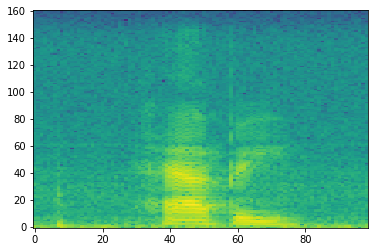

In [12]:
plt.imshow(unknwn_feats[10].T, aspect='auto', origin='lower')

In [13]:
#need to make sure any of the input is within a certain spec (of our data sizes)
#user manually check input sizes.
#as stated earlier, 99x161 was the most popular ratio by far, we'll be resizing those down by a factor of 2 due to memory problem in kaggle
def all_sampling(spec,spec_labels,unknown,background,ratio_lst,total_size):
    np.random.seed(0)
    randomize = np.arange(np.shape(spec)[0]) #index holder
    np.random.shuffle(randomize)
    spec = [cv2.resize(spec[i],dsize=None,fx=0.5,fy=0.5) for i in randomize]
    spec_labels = [spec_labels[i] for i in randomize]
    
    randomize = np.arange(np.shape(unknown)[0])
    np.random.shuffle(randomize)
    unknown = [cv2.resize(unknown[i],dsize=None,fx=0.5,fy=0.5) for i in randomize]
    
    #already resized previously
    randomize = np.arange(np.shape(background)[0])
    np.random.shuffle(randomize)
    background = [background[i] for i in randomize]
    
    #now to combine and shuffle the results
    #ratio list is of [spec,unknown,background] in that order.
    
    spec_size = math.floor(total_size*ratio_lst[0])
    unknown_size = math.floor(total_size*ratio_lst[1])
    backgnd_size = math.floor(total_size*ratio_lst[2])
    
    total_feats = [] #to hold all features
    total_labels = [] #to hold all labels of the data
    total_feats.extend(spec[:spec_size]) #should already be shuffled, non-aug
    total_labels.extend(spec_labels[:spec_size])
    #print(np.shape(total_feats),np.shape(total_labels))

    total_feats.extend(unknown[:unknown_size])
    temp = ["unknown" for i in range(unknown_size)]
    total_labels.extend(temp)
    #print(np.shape(total_feats),np.shape(total_labels))

    total_feats.extend(background[:backgnd_size])
    temp = ["background" for i in range(backgnd_size)]
    total_labels.extend(temp)
    print(np.shape(total_feats),np.shape(total_labels))
    #print(np.shape(background),np.shape(temp))
    return total_feats,total_labels

In [14]:
#this should give reasonable number of samples to try
total_feats,total_labels = all_sampling(spec=spec_feats,spec_labels=label_lst,unknown=unknwn_feats,background=background_feats,ratio_lst=[0.5,0.25,0.25],total_size=60000)

#delete, memory issue in kaggle
del spec_feats
del label_lst
del unknwn_feats
del background_feats



(53682,) (53682,)


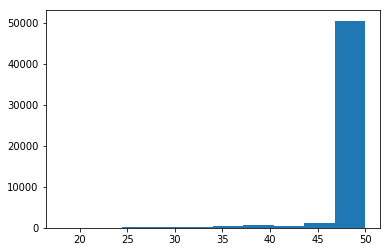

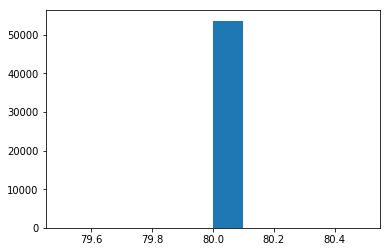

50.0 49.38878953839276 2.711500143927128


In [15]:
#to filter out data that isn't the correct sizing.
lst = []
for z in range(len(total_feats)):
    (i,j) =  np.shape(total_feats[z])
    lst.append((i,j))
    
x_dim= [i for i,j in lst]
y_dim = [j for i,j in lst]

#sns.distplot(y_dim)
plt.hist(x_dim)
plt.show()
plt.hist(y_dim)
plt.show()

#finding the mode
print(np.median(x_dim),np.mean(x_dim),np.std(x_dim))

#save memory
del x_dim
del y_dim
del lst

so it seems that we should be choosing all data with the dimension of (99,161) originally and dropping the rest wouldn't affect our training much, rather than to risk padding the data.

In [16]:
#to filter out the original non-(99,161) shapes
def features_filter(total_feats,total_labels):
    
    new_total_feats = []
    new_total_labels = []
    
    for ind in range(len(total_feats)):
        if np.shape(total_feats[ind]) == (50,80):
            new_total_feats.append(total_feats[ind])
            new_total_labels.append(total_labels[ind])
            
    return new_total_feats,new_total_labels
total_feats, total_labels = features_filter(total_feats,total_labels)

In [17]:
print(np.shape(total_feats),np.shape(total_labels))

(49853, 50, 80) (49853,)


In [18]:
label_keys = {"background":1,"unknown":2,"down":3,"go":4,"left":5,"no":6,"off":7,"on":8,"right":9,"stop":10,"up":11,"yes":12}
target = [label_keys[i] for i in total_labels]

#target = utils.to_categorical(total_labels,label_keys)
#print(np.unique(target))
#print(np.unique(target,return_counts=True))

In [19]:
y_labels = utils.to_categorical(target)
print(np.shape(y_labels))

(49853, 13)


## Training

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(total_feats, y_labels, test_size=0.25, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=0)

#to save RAM
del total_feats
del total_labels

In [21]:
np.shape(np.array(X_train))
#need to reshape from (x,50,80) to (x,50,80,1) for input
X_train = np.reshape(X_train,(-1,50,80,1))
X_val =  np.reshape(X_val,(-1,50,80,1))
X_test = np.reshape(X_test,(-1,50,80,1))

In [22]:
#we'll be using keras for prototyping first
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator #image augmentation
from keras import callbacks

history = callbacks.History() #need to be defined first

In [23]:
#using functional API
from keras import Input, layers, Model

def train_cnn():
    input_tensor = Input(shape=(50,80,1,))
    conv1 = layers.Conv2D(filters=15,kernel_size=(3,3))(input_tensor)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Activation("relu")(conv1)
    pool1 = layers.MaxPool2D(pool_size=(2,2),padding="SAME")(conv1)

    conv2 = layers.Conv2D(filters=31,kernel_size=(3,3))(pool1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Activation("relu")(conv2)
    pool2 = layers.MaxPool2D(pool_size=(2,2),padding="SAME")(conv2)

    conv3 = layers.Conv2D(filters=91,kernel_size=(3,3))(pool2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Activation("relu")(conv3)
    #pool3 = layers.MaxPool2D(pool_size=(2,2),padding="SAME")(conv3)
    pool3 = layers.AveragePooling2D(pool_size=(2,2),padding="SAME")(conv3)
    
    flat = layers.Flatten()(pool3)
    
    dropout1 = layers.Dropout(rate=0.3)(flat) #for hidden layer
    hidden = layers.Dense(units=1000,activation="relu")(dropout1)
    dropout2 = layers.Dropout(rate=0.3)(hidden) #for hidden layer
    hidden2 = layers.Dense(units=300,activation="relu")(dropout2)
    output_tensor = layers.Dense(units=13,activation="softmax")(hidden2)

    model = Model(inputs=input_tensor, outputs=output_tensor)
    model.compile(optimizer=optimizers.rmsprop(lr=0.0001), loss="categorical_crossentropy",metrics=["accuracy"])
    print(model.summary())
    
    return model


In [24]:
model1 = train_cnn()
history1 = model1.fit(np.array(X_train),np.array(y_train),validation_data=(np.array(X_val),np.array(y_val)), batch_size=600,
                      verbose=True,shuffle=True,epochs=50)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50, 80, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 78, 15)        150       
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 78, 15)        60        
_________________________________________________________________
activation_1 (Activation)    (None, 48, 78, 15)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 39, 15)        0         
_________________________________________________________________
conv2d_2 (Conv2D)    

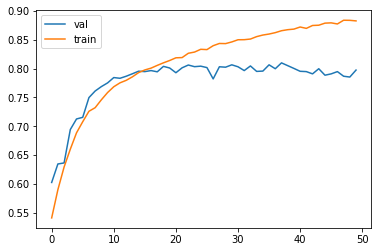

In [25]:
plt.plot(history1.epoch,history1.history["val_acc"])
plt.plot(history1.epoch,history1.history["acc"])
plt.legend(["val","train"])
plt.show()

In [26]:
#for lstm only, to reshape for input
print(np.shape(X_train))
print(np.shape(X_val))
X_train_rnn = np.reshape(X_train,newshape=(31780,50,80))
X_val_rnn = np.reshape(X_val,newshape=(5609,50,80))

(31780, 50, 80, 1)
(5609, 50, 80, 1)


In [27]:
def lstm_baseline():

    input_tensor = Input(shape=(50,80,)) #our image dimension. Unknown sample size input
    lstm = layers.Bidirectional(layers.LSTM(units=128,return_sequences=False))(input_tensor)  #need return sequence, for stacking lstm
    #In essence, the layer will contain multiple parallel LSTM units, structurally identical but each eventually "learning to remember" some different thing.
    #in literature, it's just one units with hidden cells drawn.
    hidden = layers.Dense(units=1000,activation="relu")(lstm)
    dropout = layers.Dropout(rate=0.3)(hidden)
    output_tensor = layers.Dense(13,activation="softmax")(hidden)
    
    model = Model(inputs=input_tensor, outputs=output_tensor)
    model.compile(optimizer=optimizers.RMSprop(lr=0.0001), loss="categorical_crossentropy",metrics=["accuracy"])
    print(model.summary())
    
    return model

In [28]:

model2 = lstm_baseline()
history2 = model2.fit(np.array(X_train_rnn),np.array(y_train),validation_data=(np.array(X_val_rnn),np.array(y_val)), batch_size=500,
                      verbose=True,shuffle=True,epochs=30)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 50, 80)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               214016    
_________________________________________________________________
dense_4 (Dense)              (None, 1000)              257000    
_________________________________________________________________
dense_5 (Dense)              (None, 13)                13013     
Total params: 484,029
Trainable params: 484,029
Non-trainable params: 0
_________________________________________________________________
None
Train on 31780 samples, validate on 5609 samples
Epoch 1/30
31780/31780 [==============================] - 10s 316us/step - loss: 1.5780 - acc: 0.5477 - val_loss: 1.3527 - val_acc: 0.5839
Epoch 2/30
31780/31780 [==============================] - 9s 280us/step - l

about ~75% at epochs#15 prior to overfitting

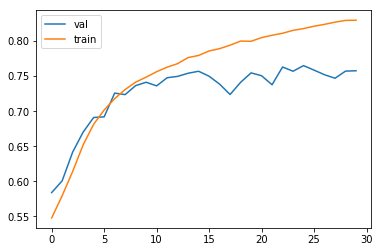

In [29]:
plt.plot(history2.epoch,history2.history["val_acc"])
plt.plot(history2.epoch,history2.history["acc"])
plt.legend(["val","train"])
plt.show()

In [30]:
#personal reference
#https://ai.stackexchange.com/questions/3156/how-to-select-number-of-hidden-layers-and-number-of-memory-cells-in-an-lstm
#stacked lstm
def lstm_model():

    input_tensor = Input(shape=(50,80,)) #our image dimension. Unknown sample size input
    lstm = layers.Bidirectional(layers.LSTM(units=128,return_sequences=True))(input_tensor)  #need return sequence, for stacking lstm
    lstm = layers.Bidirectional(layers.LSTM(units=128,return_sequences=True))(lstm)
    lstm = layers.Bidirectional(layers.LSTM(units=128))(lstm)
    hidden = layers.Dense(units=1000,activation="relu")(lstm)
    dropout = layers.Dropout(rate=0.3)(hidden)
    output_tensor = layers.Dense(13,activation="softmax")(hidden)
    
    model = Model(inputs=input_tensor, outputs=output_tensor)
    model.compile(optimizer=optimizers.RMSprop(lr=0.0001), loss="categorical_crossentropy",metrics=["accuracy"])
    print(model.summary())
    
    return model

In [31]:

model3 = lstm_model()
history3 = model3.fit(np.array(X_train_rnn),np.array(y_train),validation_data=(np.array(X_val_rnn),np.array(y_val)), batch_size=500,
                      verbose=True,shuffle=True,epochs=30)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 50, 80)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 50, 256)           214016    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 50, 256)           394240    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense_6 (Dense)              (None, 1000)              257000    
_________________________________________________________________
dense_7 (Dense)              (None, 13)                13013     
Total params: 1,272,509
Trainable params: 1,272,509
Non-trainable params: 0
_________________________________________________________________


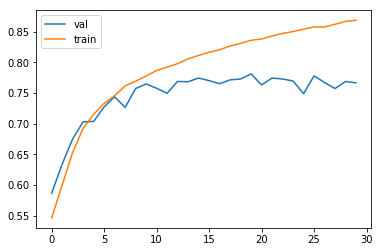

In [32]:
plt.plot(history3.epoch,history3.history["val_acc"])
plt.plot(history3.epoch,history3.history["acc"])
plt.legend(["val","train"])
plt.show()

barely touching 75% prior to overfitting

## GRU

In [33]:
##GRU
def GRU_baseline(): #baseline
    input_tensor = Input(shape=(50,80,)) #our image dimension. Unknown sample size input
    gru = layers.GRU(units=128)(input_tensor)
    
    hidden = layers.Dense(units=1000,activation="relu")(gru)
    dropout = layers.Dropout(rate=0.3)(hidden)
    output_tensor = layers.Dense(13,activation="softmax")(hidden)
    
    model = Model(inputs=input_tensor, outputs=output_tensor)
    model.compile(optimizer=optimizers.RMSprop(lr=0.0001), loss="categorical_crossentropy",metrics=["accuracy"])
    print(model.summary())
    return model

In [34]:

model4 = GRU_baseline()
history4 = model4.fit(np.array(X_train_rnn),np.array(y_train),validation_data=(np.array(X_val_rnn),np.array(y_val)), batch_size=500,
                      verbose=True,shuffle=True,epochs=100)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 50, 80)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               80256     
_________________________________________________________________
dense_8 (Dense)              (None, 1000)              129000    
_________________________________________________________________
dense_9 (Dense)              (None, 13)                13013     
Total params: 222,269
Trainable params: 222,269
Non-trainable params: 0
_________________________________________________________________
None
Train on 31780 samples, validate on 5609 samples
Epoch 1/100
31780/31780 [==============================] - 6s 176us/step - loss: 1.6702 - acc: 0.5197 - val_loss: 1.4243 - val_acc: 0.5800
Epoch 2/100
31780/31780 [==============================] - 4s 127us/step - 

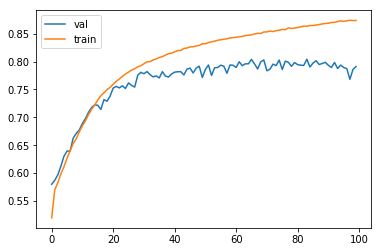

In [35]:
plt.plot(history4.epoch,history4.history["val_acc"])
plt.plot(history4.epoch,history4.history["acc"])
plt.legend(["val","train"])
plt.show()

about ~80% at best prior to overfitting around 20 epochs. GRU seems to be the way to go rather than LSTM in general here. Better computation and accuracy overall

In [36]:
#stack GRU
#testing with dropouts to see if it helps with the slight overfitting. After 4 layers of GRU, it's not getting better than 85%
def GRU_stacked_model(): #4 GRU achieves 85%
    input_tensor = Input(shape=(50,80,)) #our image dimension. Unknown sample size input
    gru = layers.GRU(units=200,dropout=0.05,recurrent_dropout=0.05,return_sequences=True)(input_tensor)
    gru = layers.GRU(units=200,dropout=0.05,recurrent_dropout=0.05,return_sequences=True)(gru)
    gru = layers.GRU(units=200,dropout=0.05,recurrent_dropout=0.05,return_sequences=True)(gru)
    gru = layers.GRU(units=200,dropout=0.05,recurrent_dropout=0.05,return_sequences=False)(gru)
    
    hidden = layers.Dense(units=1000,activation="relu")(gru)
    dropout = layers.Dropout(rate=0.2)(hidden)
    hidden = layers.Dense(units=300,activation="relu")(dropout)
    #dropout = layers.Dropout(rate=0.2)(hidden) ~85% with this dropout layer. Let's see if performance will improve without it.
    output_tensor = layers.Dense(13,activation="softmax")(dropout)
    
    model = Model(inputs=input_tensor, outputs=output_tensor)
    model.compile(optimizer=optimizers.RMSprop(lr=0.0001), loss="categorical_crossentropy",metrics=["accuracy"])
    print(model.summary())
    return model

In [37]:
model5 = GRU_stacked_model()
history5 = model5.fit(np.array(X_train_rnn),np.array(y_train),validation_data=(np.array(X_val_rnn),np.array(y_val)), batch_size=500,
                      verbose=True,shuffle=True,epochs=100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 50, 80)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 50, 200)           168600    
_________________________________________________________________
gru_3 (GRU)                  (None, 50, 200)           240600    
_________________________________________________________________
gru_4 (GRU)                  (None, 50, 200)           240600    
_________________________________________________________________
gru_5 (GRU)                  (None, 200)               240600    
_________________________________________________________________
dense_10 (Dense)             (None, 1000)              201000    
_________________________________________________________________
dropout_6 (Dropout)          (None, 1000)              0         
__________

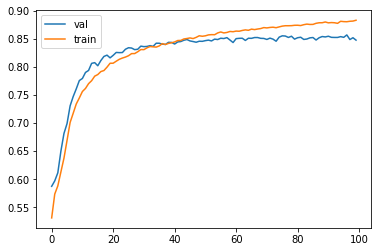

In [38]:
plt.plot(history5.epoch,history5.history["val_acc"])
plt.plot(history5.epoch,history5.history["acc"])
plt.legend(["val","train"])
plt.show()

around 81% or so with less overfitting. This is great! (normal without dropout)
with 5% dropout for each layer of GRU for both normal cells and recurrent, we are able to reach ~85% accuracy!

In [39]:
def cnn_gru_ensemble(): #a small variant
    input_tensor_cnn = Input(shape=(50,80,1,))
    conv1 = layers.Conv2D(filters=15,kernel_size=(3,3))(input_tensor_cnn)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Activation("relu")(conv1)
    pool1 = layers.MaxPool2D(pool_size=(2,2),padding="SAME")(conv1)

    
    conv2 = layers.Conv2D(filters=15,kernel_size=(3,3))(pool1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Activation("relu")(conv2)
    pool2 = layers.MaxPool2D(pool_size=(2,2),padding="SAME")(conv2)

    conv3 = layers.Conv2D(filters=15,kernel_size=(3,3))(pool2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Activation("relu")(conv3)
    pool3 = layers.MaxPool2D(pool_size=(2,2),padding="SAME")(conv3)
    output_tensor_cnn = layers.Flatten()(pool3)
    #model_cnn = Model(inputs=input_tensor_cnn, outputs=output_tensor_cnn)
    
    ##############
    input_tensor_gru = Input(shape=(50,80,)) #our image dimension. Unknown sample size input
    gru = layers.GRU(units=200,dropout=0.05,recurrent_dropout=0.05,return_sequences=True)(input_tensor_gru)
    gru = layers.GRU(units=200,dropout=0.05,recurrent_dropout=0.05,return_sequences=True)(gru)
    gru = layers.GRU(units=200,dropout=0.05,recurrent_dropout=0.05,return_sequences=True)(gru)
    gru = layers.GRU(units=200,dropout=0.05,recurrent_dropout=0.05,return_sequences=False)(gru)
    output_tensor_gru = layers.Dense(units=500,activation="relu")(gru)
    #model_gru = Model(inputs=input_tensor_gru, outputs=output_tensor_gru)
    ##############
    combined = layers.concatenate([output_tensor_cnn,output_tensor_gru])
    dropout = layers.Dropout(rate=0.2)(combined)
    hidden = layers.Dense(units=1000,activation="relu")(dropout)
    dropout = layers.Dropout(rate=0.2)(hidden)
    hidden = layers.Dense(units=300,activation="relu")(dropout)
    dropout = layers.Dropout(rate=0.2)(hidden)
    output_tensor = layers.Dense(13,activation="softmax")(dropout)
    
    model = Model(inputs=[input_tensor_cnn,input_tensor_gru], outputs=output_tensor)
    model.compile(optimizer=optimizers.RMSprop(lr=0.0001), loss="categorical_crossentropy",metrics=["accuracy"])
    print(model.summary())
    
    return model

In [40]:
model6 = cnn_gru_ensemble()
history6 = model6.fit([np.array(X_train),np.array(X_train_rnn)],np.array(y_train),validation_data=([np.array(X_val),np.array(X_val_rnn)],np.array(y_val)), batch_size=600,
                      verbose=True,shuffle=True,epochs=50)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 50, 80, 1)    0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 48, 78, 15)   150         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 48, 78, 15)   60          conv2d_4[0][0]                   
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 48, 78, 15)   0           batch_normalization_4[0][0]      
__________________________________________________________________________________________________
max_poolin

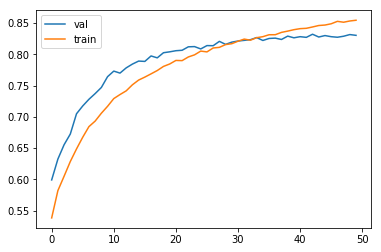

In [41]:
plt.plot(history6.epoch,history6.history["val_acc"])
plt.plot(history6.epoch,history6.history["acc"])
plt.legend(["val","train"])
plt.show()

about 83% at 40 epochs prior to overfitting. Seems like ensemble didn't work well in this case

## Personal Notes on models used

#The key idea here is that RNN steps cannot be parallelized because they are connected: each one needs the result of the previous one to run. Therefore it's computationally intensive.

#model2
def lstm_model():

    input_tensor = Input(shape=(50,80,)) #our image dimension. Unknown sample size input
    lstm = layers.LSTM(units=11,return_sequences=True)(input_tensor)  #need return sequence, for stacking lstm
    #In essence, the layer will contain multiple parallel LSTM units, structurally identical but each eventually "learning to remember" some different thing.
    #in literature, it's just one units with hidden cells drawn.
    lstm = layers.Bidirectional(layers.LSTM(units=21,return_sequences=True))(lstm)
    lstm = layers.Bidirectional(layers.LSTM(units=21))(lstm)
    hidden = layers.Dense(units=1000,activation="relu")(lstm)
    output_tensor = layers.Dense(13,activation="softmax")(hidden)
    
    model = Model(inputs=input_tensor, outputs=output_tensor)
    model.compile(optimizer=optimizers.RMSprop(lr=0.00025), loss="categorical_crossentropy",metrics=["accuracy"])
    print(model.summary())
    
    return model
	
#max accuracy 77%. Overfitting post ~170 epochs


#model3
def lstm_model():

    input_tensor = Input(shape=(50,80,)) #our image dimension. Unknown sample size input
    lstm = layers.Bidirectional(layers.LSTM(units=11,return_sequences=False))(input_tensor)  #no returning sequences
    hidden = layers.Dense(units=1000,activation="relu")(lstm)
    output_tensor = layers.Dense(13,activation="softmax")(hidden)
    
    model = Model(inputs=input_tensor, outputs=output_tensor)
    model.compile(optimizer=optimizers.RMSprop(lr=0.00025), loss="categorical_crossentropy",metrics=["accuracy"])
    print(model.summary())
    
    return model
#max accuracy 72%. Overfitting post ~40 epochs


#model 4
def lstm_model():

    input_tensor = Input(shape=(50,80,)) #our image dimension. Unknown sample size input
    lstm = layers.Bidirectional(layers.LSTM(units=50,return_sequences=False))(input_tensor)  #need return sequence, for stacking lstm
    #In essence, the layer will contain multiple parallel LSTM units, structurally identical but each eventually "learning to remember" some different thing.
    #in literature, it's just one units with hidden cells drawn.
    #lstm = layers.Bidirectional(layers.LSTM(units=21,return_sequences=True))(lstm)
    #lstm = layers.Bidirectional(layers.LSTM(units=21))(lstm)
    hidden = layers.Dense(units=1000,activation="relu")(lstm)
    hidden = layers.Dropout(rate=0.3)(hidden)
    output_tensor = layers.Dense(13,activation="softmax")(hidden)
    
    model = Model(inputs=input_tensor, outputs=output_tensor)
    model.compile(optimizer=optimizers.RMSprop(lr=0.00025), loss="categorical_crossentropy",metrics=["accuracy"])
    print(model.summary())
    
    return model
	
#max accuracy 74%. Overfitting post ~25 epochs

#model 5
def lstm_model():

    input_tensor = Input(shape=(50,80,)) #our image dimension. Unknown sample size input
    lstm = layers.Bidirectional(layers.LSTM(units=11,return_sequences=True))(input_tensor)  #need return sequence, for stacking lstm
    #In essence, the layer will contain multiple parallel LSTM units, structurally identical but each eventually "learning to remember" some different thing.
    #in literature, it's just one units with hidden cells drawn.
    lstm = layers.Bidirectional(layers.LSTM(units=11,return_sequences=True))(lstm)
    lstm = layers.Bidirectional(layers.LSTM(units=11,return_sequences=True))(lstm)
    lstm = layers.Bidirectional(layers.LSTM(units=11,return_sequences=True))(lstm)
    lstm = layers.Bidirectional(layers.LSTM(units=11))(lstm)
    hidden = layers.Dense(units=1000,activation="relu")(lstm)
    dropout = layers.Dropout(rate=0.3)(hidden)
    output_tensor = layers.Dense(13,activation="softmax")(dropout)
    
    model = Model(inputs=input_tensor, outputs=output_tensor)
    model.compile(optimizer=optimizers.RMSprop(lr=0.00025), loss="categorical_crossentropy",metrics=["accuracy"])
    print(model.summary())
    
    return model
#max accuracy 79%. Overfitting post 15 epochs.

#model6
#higher number of units

def lstm_model():

    input_tensor = Input(shape=(50,80,)) #our image dimension. Unknown sample size input
    lstm = layers.Bidirectional(layers.LSTM(units=128,return_sequences=True))(input_tensor)
    lstm = layers.Bidirectional(layers.LSTM(units=128,return_sequences=True))(lstm)
    lstm = layers.Bidirectional(layers.LSTM(units=128,return_sequences=False))(lstm)
    
    hidden = layers.Dense(units=1000,activation="relu")(lstm)
    dropout = layers.Dropout(rate=0.3)(hidden)
    hidden2 = layers.Dense(units=300,activation="relu")(dropout)
    output_tensor = layers.Dense(13,activation="softmax")(hidden2)
    
    model = Model(inputs=input_tensor, outputs=output_tensor)
    model.compile(optimizer=optimizers.RMSprop(lr=0.0001), loss="categorical_crossentropy",metrics=["accuracy"])
    print(model.summary())
    
    return model
    
#max accuracy 75%, overfitting at 10 epochs

##GRU
def GRU_baseline(): #baseline
    input_tensor = Input(shape=(50,80,)) #our image dimension. Unknown sample size input
    gru = layers.GRU(units=128)(input_tensor)
    
    hidden = layers.Dense(units=1000,activation="relu")(gru)
    dropout = layers.Dropout(rate=0.3)(hidden)
    output_tensor = layers.Dense(13,activation="softmax")(hidden)
    
    model = Model(inputs=input_tensor, outputs=output_tensor)
    model.compile(optimizer=optimizers.RMSprop(lr=0.0001), loss="categorical_crossentropy",metrics=["accuracy"])
    print(model.summary())
    return model
    
#about 80% accuracy and overfit at around 20 epochs! GRU > LSTM in this case for both performance and computation

#stack GRU
def GRU_stacked_model():
    input_tensor = Input(shape=(50,80,)) #our image dimension. Unknown sample size input
    gru = layers.GRU(units=200,return_sequences=True)(input_tensor)
    gru = layers.GRU(units=200,return_sequences=True)(gru)
    gru = layers.GRU(units=200,return_sequences=True)(gru)
    gru = layers.GRU(units=200,return_sequences=False)(gru)
    
    hidden = layers.Dense(units=1000,activation="relu")(gru)
    dropout = layers.Dropout(rate=0.3)(hidden)
    hidden = layers.Dense(units=300,activation="relu")(dropout)
    dropout = layers.Dropout(rate=0.2)(hidden)
    output_tensor = layers.Dense(13,activation="softmax")(dropout)
    
    model = Model(inputs=input_tensor, outputs=output_tensor)
    model.compile(optimizer=optimizers.RMSprop(lr=0.00005), loss="categorical_crossentropy",metrics=["accuracy"])
    print(model.summary())
    return model

#about 81% with little overfitting (84%) at 50 epochs. 


#stack GRU
#testing with dropouts to see if it helps with the slight overfitting
def GRU_stacked_model():
    input_tensor = Input(shape=(50,80,)) #our image dimension. Unknown sample size input
    gru = layers.GRU(units=200,dropout=0.05,recurrent_dropout=0.05,return_sequences=True)(input_tensor)
    gru = layers.GRU(units=200,dropout=0.05,recurrent_dropout=0.05,return_sequences=True)(gru)
    gru = layers.GRU(units=200,dropout=0.05,recurrent_dropout=0.05,return_sequences=True)(gru)
    gru = layers.GRU(units=200,dropout=0.05,recurrent_dropout=0.05,return_sequences=False)(gru)
    
    hidden = layers.Dense(units=1000,activation="relu")(gru)
    dropout = layers.Dropout(rate=0.2)(hidden)
    hidden = layers.Dense(units=300,activation="relu")(dropout)
    dropout = layers.Dropout(rate=0.2)(hidden)
    output_tensor = layers.Dense(13,activation="softmax")(dropout)
    
    model = Model(inputs=input_tensor, outputs=output_tensor)
    model.compile(optimizer=optimizers.RMSprop(lr=0.0001), loss="categorical_crossentropy",metrics=["accuracy"])
    print(model.summary())
    return model
    
#85% accuracy and no overfitting at 50 epochs
#################
def cnn_gru_ensemble(): #a small variant
    input_tensor_cnn = Input(shape=(50,80,1,))
    conv1 = layers.Conv2D(filters=15,kernel_size=(3,3))(input_tensor_cnn)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Activation("relu")(conv1)
    pool1 = layers.MaxPool2D(pool_size=(2,2),padding="SAME")(conv1)

    
    conv2 = layers.Conv2D(filters=15,kernel_size=(3,3))(pool1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Activation("relu")(conv2)
    pool2 = layers.MaxPool2D(pool_size=(2,2),padding="SAME")(conv2)

    conv3 = layers.Conv2D(filters=15,kernel_size=(3,3))(pool2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Activation("relu")(conv3)
    pool3 = layers.MaxPool2D(pool_size=(2,2),padding="SAME")(conv3)
    output_tensor_cnn = layers.Flatten()(pool3)
    #model_cnn = Model(inputs=input_tensor_cnn, outputs=output_tensor_cnn)
    
    ##############
    input_tensor_gru = Input(shape=(50,80,)) #our image dimension. Unknown sample size input
    gru = layers.GRU(units=200,dropout=0.05,recurrent_dropout=0.05,return_sequences=True)(input_tensor_gru)
    gru = layers.GRU(units=200,dropout=0.05,recurrent_dropout=0.05,return_sequences=True)(gru)
    gru = layers.GRU(units=200,dropout=0.05,recurrent_dropout=0.05,return_sequences=True)(gru)
    gru = layers.GRU(units=200,dropout=0.05,recurrent_dropout=0.05,return_sequences=False)(gru)
    output_tensor_gru = layers.Dense(units=1000,activation="relu")(gru)
    #model_gru = Model(inputs=input_tensor_gru, outputs=output_tensor_gru)
    ##############
    combined = layers.concatenate([output_tensor_cnn,output_tensor_gru])
    dropout = layers.Dropout(rate=0.2)(combined)
    hidden = layers.Dense(units=1000,activation="relu")(dropout)
    dropout = layers.Dropout(rate=0.2)(hidden)
    hidden = layers.Dense(units=300,activation="relu")(dropout)
    dropout = layers.Dropout(rate=0.2)(hidden)
    output_tensor = layers.Dense(13,activation="softmax")(dropout)
    
    model = Model(inputs=[input_tensor_cnn,input_tensor_gru], outputs=output_tensor)
    model.compile(optimizer=optimizers.RMSprop(lr=0.0001), loss="categorical_crossentropy",metrics=["accuracy"])
    print(model.summary())
    
    return model
about 83% at 40 epochs prior to overfitting